In [1]:
import pickle
import networkx as nx

In [3]:
user_layer = pickle.load(open('../Multilayer Network/user_layer.pickle', 'rb'))

In [27]:
len(user_layer.nodes)

16976

In [8]:
import community

# Louvain algorithm
partition = community.best_partition(user_layer)

# Compute metrics
modularity = community.modularity(partition, user_layer)
community_sizes = {}
community_embeddedness = {}

for com in set(partition.values()):
    nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    community_sizes[com] = len(nodes)
    embeddedness = 0
    for node in nodes:
        embeddedness += sum([1 for n in user_layer.neighbors(node) if partition[n] != com])
    community_embeddedness[com] = embeddedness

In [32]:
import json
filtering = lambda x: x[1]>0

with open('ce.txt', 'w') as f:
    f.write(json.dumps(dict(filter(filtering, community_embeddedness.items()))))

624

In [31]:
import json
filtering = lambda x: x[1]>1

with open('cs.txt', 'w') as f:
    f.write(json.dumps(dict(filter(filtering, community_sizes.items()))))

10519

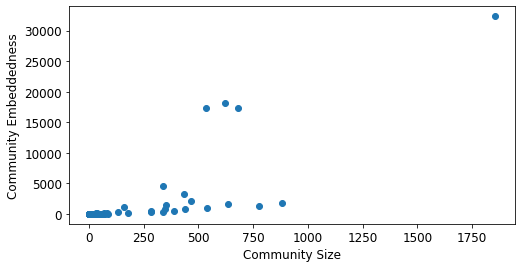

In [21]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(list(community_sizes.values()), list(community_embeddedness.values()))
ax.set_xlabel("Community Size")
ax.set_ylabel("Community Embeddedness")
plt.savefig('CE_CS.pdf')
plt.show()

In [37]:
key_users = pickle.load(open('key_users.pickle', 'rb'))

In [39]:
filtering = lambda x: x[1]==88
biggest_community = dict(filter(filtering, partition.items()))
print(len(key_users))
print(len(biggest_community))
print(len(set(key_users).intersection(set(biggest_community.keys()))))

3834
1854
1850


In [75]:
MLN = pickle.load(open('../Multilayer Network/MLN.pickle', 'rb'))
content_social_layer = nx.Graph()
for c, data in MLN.nodes(data=True):
    if data['layer'] == 'content':
        content_social_layer.add_node(c)

In [76]:
multi_layer_edges = [(u,v,data) for u,v,data in MLN.edges(data=True) if data['layer']=='multi_c_s']
sp_edges = [(s1,s2) for s1,s2,data in MLN.edges(data=True) if data['layer']=='socialphenomenon']

In [77]:
social_to_content_map = {}
for edge in multi_layer_edges:
    if edge[1] not in social_to_content_map:
        social_to_content_map[edge[1]] = []
    social_to_content_map[edge[1]].append(edge[0])
social_to_content_map_filtered = {}
for s in social_to_content_map:
    if len(social_to_content_map[s]) > 1:
        social_to_content_map_filtered[s] = social_to_content_map[s]

In [81]:
sp_edges = [(s1,s2) for s1,s2 in sp_edges if s1 in social_to_content_map_filtered.keys() or s2 in social_to_content_map_filtered.keys()]
result = {}
for social_node, content_nodes in social_to_content_map_filtered.items():
    for i, c1 in enumerate(content_nodes):
        for c2 in content_nodes[i+1:]:
            try:
                result[(c1,c2)].extend(social_node)
                result[(c1,c2)] = list(set(result[(c1,c2)]))
            except:
                result[(c1,c2)] = [social_node]

In [84]:
for res in result.keys():
    content_social_layer.add_edge(res[0], res[1], label=result[res])
pickle.dump(content_social_layer, open('content_social_layer.pickle', 'wb'))

In [2]:
content_social_layer = pickle.load(open('content_social_layer.pickle', 'rb'))

In [89]:
b_net = user_layer.subgraph(list(biggest_community.keys()))
pickle.dump(b_net, open('b_net.pickle', 'wb'))

In [2]:
b_net = pickle.load(open('b_net.pickle', 'rb'))
b_content_layer = nx.Graph()
for b, data in b_net.nodes(data=True):
    b_content_layer.add_node(b)

In [3]:
content_social_layer = pickle.load(open('content_social_layer.pickle', 'rb'))
sc_edges = [(c1,c2,data) for c1,c2,data in content_social_layer.edges(data=True)]
del content_social_layer

In [3]:
MLN = pickle.load(open('../Multilayer Network/MLN.pickle', 'rb'))

In [4]:
multi_layer_edges = []
for u,v,data in MLN.edges(data=True):
    if data['layer']=='multi_u_c':
        if b_content_layer.has_node(u):
            multi_layer_edges.append((u,v))
del MLN

In [5]:
content_to_b_map = {}
for edge in multi_layer_edges:
    if edge[1] not in content_to_b_map:
        content_to_b_map[edge[1]] = []
    content_to_b_map[edge[1]].append(edge[0])
content_to_b_map_filtered = {}
for b in content_to_b_map:
    if len(content_to_b_map[b]) > 1:
        content_to_b_map_filtered[b] = content_to_b_map[b]

In [7]:
content_social_layer = pickle.load(open('content_social_layer.pickle', 'rb'))
sc_edges = [(c1,c2,data) for c1,c2,data in content_social_layer.edges(data=True) if c1 in content_to_b_map_filtered.keys() or c2 in content_to_b_map_filtered.keys()]
result = {}
for content_node, user_nodes in content_to_b_map_filtered.items():
    for c1,c2,data in sc_edges:
        subtypes = []
        if c1 == content_node or c2 == content_node:
            subtypes.extend(data['label'])
        subtypes = list(set(subtypes))
        for i, u1 in enumerate(user_nodes):
            for u2 in user_nodes[i+1:]:
                try:
                    result[(u1,u2)].extend(subtypes)
                    result[(u1,u2)] = list(set(result[(u1,u2)]))
                except:
                    result[(u1,u2)] = subtypes

In [9]:
for res in result.keys():
    b_content_layer.add_edge(res[0], res[1], label=result[res])
pickle.dump(b_content_layer, open('b_content_layer.pickle', 'wb'))

In [15]:
print(len(b_content_layer.nodes))
print(len(b_content_layer.edges))
print(nx.number_of_isolates(b_content_layer))
print(nx.density(b_content_layer))

1854
291
1600
0.00016940952919869293


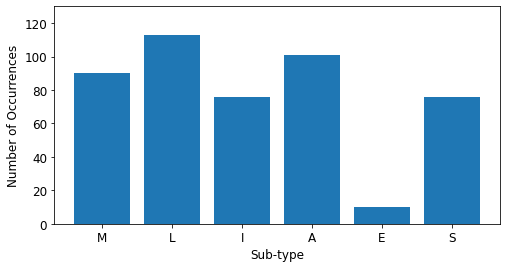

In [21]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})


plt.figure(figsize=(8,4))
subtype_count = {}
for value_list in result.values():
    for subtype in value_list:
        if subtype in subtype_count:
            subtype_count[subtype] += 1
        else:
            subtype_count[subtype] = 1

plt.bar(subtype_count.keys(), subtype_count.values())
plt.ylim(0,130)
plt.xlabel("Sub-type")
plt.ylabel("Number of Occurrences")
plt.savefig('subtype_occ.pdf')
plt.show()

In [22]:
subtype_count

{'M': 90, 'L': 113, 'I': 76, 'A': 101, 'E': 10, 'S': 76}